Visualizing Notebook
====================

This notebook consist of 4 section below:

1. Load libraries
1. Load the model
1. Load datasets
1. Check datasets
1. Define necessary function to use tf-keras-vis
1. GradCAM++
1. SmoothGrad

When you want to attempt more visualizing, please modify section 3, 6 and 7.

Load libraries
--------------

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from glob import glob
from random import shuffle

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard)
from tensorflow.keras.layers import (AvgPool2D, Conv2D, Dense, GlobalAvgPool2D, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

Load the model
--------------

In [2]:
model = tf.keras.models.load_model('5layers-32filters-8batch-0.0003lr-None.57epoch.h5')
model.summary()

Model: "model_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, None, 1)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    288       
_________________________________________________________________
pool1 (AveragePooling2D)     (None, None, None, 32)    0         
_________________________________________________________________
conv2 (Conv2D)               (None, None, None, 64)    18432     
_________________________________________________________________
pool2 (AveragePooling2D)     (None, None, None, 64)    0         
_________________________________________________________________
conv3 (Conv2D)               (None, None, None, 128)   73728     
_________________________________________________________________
pool3 (AveragePooling2D)     (None, None, None, 128)   0 

Load datasets
-------------

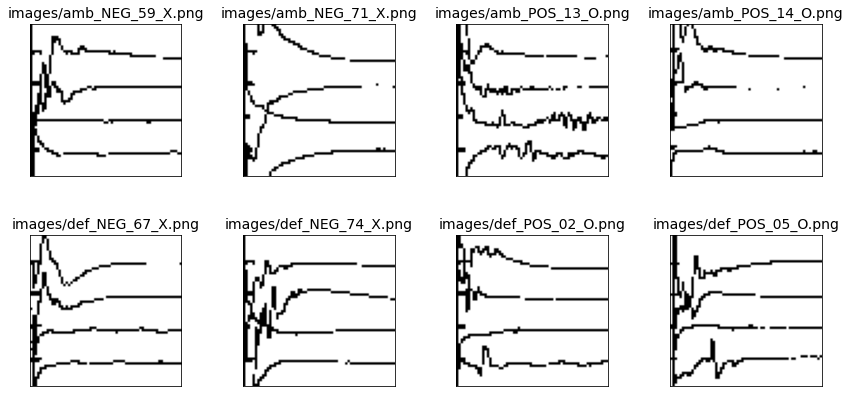

In [3]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

files = glob('images/*.png')
files.sort()
images = [Image.open(f) for f in files]
images = [img.resize((64, 64)) for img in images]
X = np.array([np.array(img) / 1. for img in images])
X = np.expand_dims(X, axis=-1)

subprot_args = {
    'nrows': 2,
    'ncols': 4,
    'figsize': (12, 6),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subprot_args)
for i, (path, img) in enumerate(zip(files, images)):
    ax[i//4][i%4].set_title(path, fontsize=14)
    ax[i//4][i%4].imshow(img)
plt.tight_layout()
plt.show()

Check datasets
--------------

In [4]:
annotation = np.array([1. if 'NEG' in f else 0. for f in files])
print('annotation->', annotation)

preds = model.predict(X)
print('preds->', preds)

# 4th image's prediction is NOT correct.
accuracy = annotation == np.reshape(preds > 0.5, (-1,))
print('accuracy->', accuracy)

annotation-> [1. 1. 0. 0. 1. 1. 0. 0.]
preds-> [[1.0000000e+00]
 [9.9999475e-01]
 [5.7946261e-05]
 [9.9971718e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [6.2365260e-05]
 [3.5684289e-11]]
accuracy-> [ True  True  True False  True  True  True  True]


Define necessary function to use tf-keras-vis
---------------------------------------------

In [5]:
import tensorflow.keras.backend as K

def loss(output):
    return output * tf.where(preds > 0.5, 1., -1.)

# Define modifier to replace a sigmoid function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

GradCAM++
---------

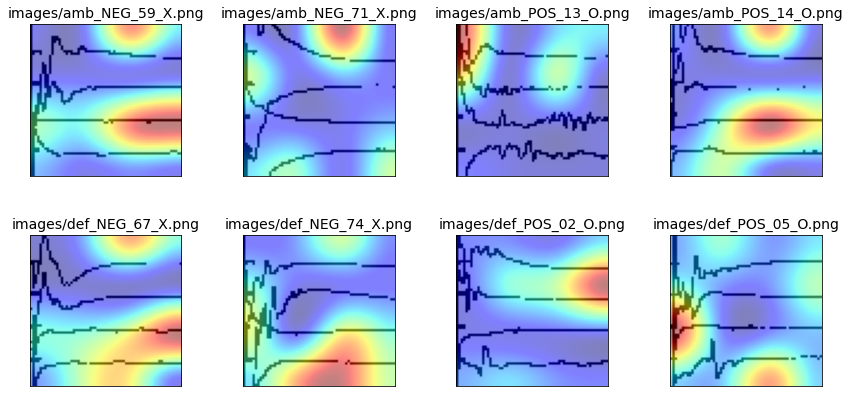

In [6]:
from matplotlib import cm
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize

# Create Gradcam++ object
gradcam = GradcamPlusPlus(model, model_modifier, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(loss, X)
cam = normalize(cam)

f, ax = plt.subplots(**subprot_args)
for i, path in enumerate(files):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i//4][i%4].set_title(path, fontsize=14)
    ax[i//4][i%4].imshow(images[i])
    ax[i//4][i%4].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

SmoothGrad
----------

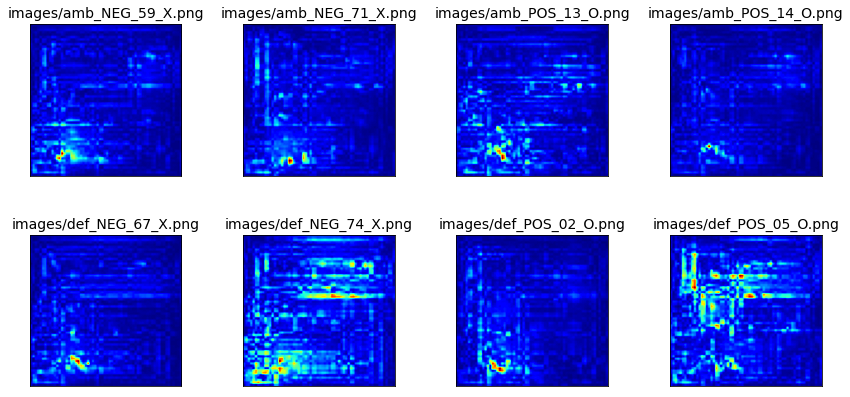

In [7]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object
saliency = Saliency(model, model_modifier, clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss, X, smooth_samples=20, smooth_noise=0.1)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subprot_args)
for i, path in enumerate(files):
    ax[i//4][i%4].set_title(path, fontsize=14)
    ax[i//4][i%4].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('smoothgrad-july-7-01.png')
plt.show()